# Problem Set 1: Analysis of racial disparities in felony sentencing

# 0. Load packages and imports

In [46]:
## basic functionality
import pandas as pd
import numpy as np
import re

## can add others if you need them

## repeated printouts
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## 0.1: Load the data (0 points)

Load the `sentencing_asof0405.csv` data

*Notes*: You may receive a warning about mixed data types upon import; feel free to ignore

In [49]:
df = df_sentencing = pd.read_csv("sentencing_asof0405.csv")

/var/folders/39/n92n7brd1t5_t9yz154q31600000gn/T/ipykernel_28050/961771456.py:1: DtypeWarning: Columns (10,11,14,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df = df_sentencing = pd.read_csv("sentencing_asof0405.csv")


## 0.2: Print head, dimensions, info (0 points)

In [51]:
print(df.head())
print(df.shape)
print(df.info())

        CASE_ID  CASE_PARTICIPANT_ID          RECEIVED_DATE  \
0  149765331439         175691153649  8/15/1984 12:00:00 AM   
1  149765331439         175691153649  8/15/1984 12:00:00 AM   
2  149765331439         175691153649  8/15/1984 12:00:00 AM   
3  149765331439         175691153649  8/15/1984 12:00:00 AM   
4  149765331439         175691153649  8/15/1984 12:00:00 AM   

    OFFENSE_CATEGORY  PRIMARY_CHARGE_FLAG    CHARGE_ID  CHARGE_VERSION_ID  \
0  PROMIS Conversion                False  50510112469       116304211997   
1  PROMIS Conversion                False  50510213021        98265074680   
2  PROMIS Conversion                False  50516447217       131972895911   
3  PROMIS Conversion                False  50516497493       131966356472   
4  PROMIS Conversion                False  50516648320        98059642859   

  DISPOSITION_CHARGED_OFFENSE_TITLE  CHARGE_COUNT        DISPOSITION_DATE  \
0               FIRST DEGREE MURDER             2  12/17/2014 12:00:00 AM   
1   

# Part one: data cleaning/interpretation

## 1.1: Understanding the unit of analysis (5 points)

- Print the number of unique values for the following columns. Do so in a way that avoids copying/pasting code for 
the three:

    - Cases (`CASE_ID`)
    - People in that case (`CASE_PARTICIPANT_ID`)
    - Charges (`CHARGE_ID`)

- Write a couple sentences on the following and show an example of each (e.g., a case involving multiple people):
    
    - Why there are more unique people than unique cases?
 
More unique people than unique cases because it is likely that cases will involve multiple people (i.e. they were found together at the crime scene or collaborated)

    - Why there are more unique charges than unique people?

More unique charges than unique people as a person could be charged for more than one thing

- Print the mean and median number of charges per case/participant 

- Print the mean and median number of participants per case

- Does the data seem to enable us to follow the same defendant across different cases they're charged in? Write 1 sentence in support of your conclusion.

The data should allow us to follow the same defendant across different cases because of the unique participant IDs, further shown by how a participant can have more than 1 charge.


In [15]:
columns = ["CASE_ID", "CASE_PARTICIPANT_ID", "CHARGE_ID"]
unique_values = [df[col].nunique() for col in columns]
unique_values

case_people = df.groupby("CASE_ID").agg({"CASE_PARTICIPANT_ID":"count"}).reset_index()
case_people

charge_people = df.groupby("CASE_PARTICIPANT_ID").agg({"CHARGE_ID":"count"}).reset_index()
charge_people

# Calculate the mean and median number of charges per case
charges_per_case = df.groupby('CASE_ID')['CHARGE_COUNT'].sum()
mean_charges_per_case = charges_per_case.mean()
median_charges_per_case = charges_per_case.median()

# Calculate the mean and median number of charges per participant
charges_per_participant = df.groupby('CASE_PARTICIPANT_ID')['CHARGE_COUNT'].sum()
mean_charges_per_participant = charges_per_participant.mean()
median_charges_per_participant = charges_per_participant.median()

# Print the mean and median number of charges per case/participant
print("Mean Charges per Case", mean_charges_per_case)
print("Median Charges per Case", median_charges_per_case)
print("Mean Charges per Participant", mean_charges_per_participant)
print("Median Charges per Participant", median_charges_per_participant)

# Calculate the mean and median number of participants per case
participants_per_case = df.groupby('CASE_ID')['CASE_PARTICIPANT_ID'].nunique()
mean_participants_per_case = participants_per_case.mean()
median_participants_per_case = participants_per_case.median()

# Print the mean and median number of participants per case
print("Mean Participants per Case", mean_participants_per_case)
print("Median Participants per Case", median_participants_per_case)

[197519, 211977, 229015]

,CASE_ID,CASE_PARTICIPANT_ID
0,149765331439,11
1,150065796098,6
2,154524891354,1
3,154954734978,1
4,155222744754,1
...,...,...
197514,445516248775,1
197515,445527409730,1
197516,445587767000,1
197517,445592613204,1


,CASE_PARTICIPANT_ID,CHARGE_ID
0,96757475659,1
1,97064562856,1
2,97249060542,1
3,97581722610,5
4,97603050731,3
...,...,...
211972,905289187184,1
211973,905322500577,1
211974,905518794790,1
211975,905533705601,1


Mean Charges per Case 2.697224064520375
Median Charges per Case 1.0
Mean Charges per Participant 2.5132585138953756
Median Charges per Participant 1.0
Mean Participants per Case 1.0731980214561636
Median Participants per Case 1.0


## 1.2.1: Which offense is final? (3 points)

- First, read the data documentation [link](https://datacatalog.cookcountyil.gov/api/views/tg8v-tm6u/files/8597cdda-f7e1-44d1-b0ce-0a4e43f8c980?download=true&filename=CCSAO%20Data%20Glossary.pdf) and summarize in your own words the differences between `OFFENSE_CATEGORY` and `UPDATED_OFFENSE_CATEGORY`
Offense category is the initial description of the charge before more details are acquired. The updated \noffense cateory is a later adjustment after the primary charge has been finalized post evidence review.


- Construct an indicator `is_changed_offense` that's True for case-participant-charge observations (rows) where there's a difference between the original charge (offense category) and the most current charge (updated offense category). What are some of the more common changed offenses? (can just print result of sort_values based on original offense category)

- Print one example of a changed offense from one of these categories and comment on what the reason may be
Reason (also commented in the code): A reason why the charege would change from aggravated battery to home invasion is because a neighbor could've seen someone break into the house and steal but no physical harm was actually done


In [18]:
df.columns

# Assuming the DataFrame has columns 'original_offense' and 'updated_offense'
# Create the indicator for changed offenses
df['is_changed_offense'] = df['OFFENSE_CATEGORY'] != df['UPDATED_OFFENSE_CATEGORY']

# Filter the DataFrame for changed offenses
changed_offenses = df[df['is_changed_offense']]

# Count the occurrences of each original offense category and sort them
common_changed_offenses = changed_offenses['OFFENSE_CATEGORY'].value_counts().reset_index()
common_changed_offenses.columns = ['OFFENSE_CATEGORY', 'count']

# Sort the result based on count in descending order to find the most common offenses
sorted_common_changed_offenses = common_changed_offenses.sort_values(by='count', ascending=False)

# Print the most common changed offenses
print(sorted_common_changed_offenses)
example_changed_offense = changed_offenses.iloc[7000]  # Get the first example

print("\nExample of a Changed Offense:")
print(example_changed_offense)
#A reason why the charege would change from aggravated battery to home invasion is because a neighbor could've seen someone break into the house and steal but no physical harm was actually done

Index(['CASE_ID', 'CASE_PARTICIPANT_ID', 'RECEIVED_DATE', 'OFFENSE_CATEGORY',
       'PRIMARY_CHARGE_FLAG', 'CHARGE_ID', 'CHARGE_VERSION_ID',
       'DISPOSITION_CHARGED_OFFENSE_TITLE', 'CHARGE_COUNT', 'DISPOSITION_DATE',
       'DISPOSITION_CHARGED_CHAPTER', 'DISPOSITION_CHARGED_ACT',
       'DISPOSITION_CHARGED_SECTION', 'DISPOSITION_CHARGED_CLASS',
       'DISPOSITION_CHARGED_AOIC', 'CHARGE_DISPOSITION',
       'CHARGE_DISPOSITION_REASON', 'SENTENCE_JUDGE', 'SENTENCE_COURT_NAME',
       'SENTENCE_COURT_FACILITY', 'SENTENCE_PHASE', 'SENTENCE_DATE',
       'SENTENCE_TYPE', 'CURRENT_SENTENCE_FLAG', 'COMMITMENT_TYPE',
       'COMMITMENT_TERM', 'COMMITMENT_UNIT', 'LENGTH_OF_CASE_in_Days',
       'AGE_AT_INCIDENT', 'RACE', 'GENDER', 'INCIDENT_CITY',
       'INCIDENT_BEGIN_DATE', 'INCIDENT_END_DATE', 'LAW_ENFORCEMENT_AGENCY',
       'LAW_ENFORCEMENT_UNIT', 'ARREST_DATE', 'FELONY_REVIEW_DATE',
       'FELONY_REVIEW_RESULT', 'ARRAIGNMENT_DATE', 'UPDATED_OFFENSE_CATEGORY'],
      dtype='objec

                OFFENSE_CATEGORY  count
0              PROMIS Conversion   6394
1                            DUI   3896
2   UUW - Unlawful Use of Weapon   2155
3                  Other Offense   2125
4             Aggravated Battery   1927
..                           ...    ...
83                       Perjury      4
84                  Prostitution      3
85    Compelling Gang Membership      2
86       Benefit Recipient Fraud      2
87             Violate Bail Bond      2

[88 rows x 2 columns]

Example of a Changed Offense:
CASE_ID                                                    379330610431
CASE_PARTICIPANT_ID                                        700843007499
RECEIVED_DATE                                     7/12/2010 12:00:00 AM
OFFENSE_CATEGORY                                     Aggravated Battery
PRIMARY_CHARGE_FLAG                                               False
CHARGE_ID                                                  336358724178
CHARGE_VERSION_ID                 

## 1.2.2: Simplifying the charges (5 points)

Using the field (`UPDATED_OFFENSE_CATEGORY`), create a new field, `simplified_offense_derived`, that simplifies the many offense categories into broader buckets using the following process:

First, combine all offenses beginning with "Aggravated" into a single category without that prefix (e.g., Aggravated Battery and Battery just becomes Battery)

Then:
- Combine all offenses with arson into a single arson category (`Arson`)
- Combine all offenses with homicide into a single homicide category (`Homicide`)
- Combine all offenses with vehicle/vehicular in the name into a single vehicle category (`Vehicle-related`)
- Combine all offenses with battery in the name into a single battery category (`Battery`)

Try to do so efficiently (e.g., using map and a dictionary or np.select rather than separate line for each recoded offense)

Print the difference between the # of unique offenses in the original `UPDATED_OFFENSE_CATEGORY` field and the # of unique offenses in your new `simplified_offense_derived` field


In [21]:
#Taking out aggravated prefix
df["UPDATED_OFFENSE_CATEGORY"] = df["UPDATED_OFFENSE_CATEGORY"].str.replace("Aggravated ", "", case=False)

#Setting up the conversion_dict method
conversion_dict = {
    "arson": "Arson",
    "homicide": "Homicide",
    "vehicle": "Vehicle-related",
    "vehicular": "Vehicle-related",
    "battery": "Battery"
}

# Step 3: Apply the mapping using np.select
conditions = [df["UPDATED_OFFENSE_CATEGORY"].str.contains(key, case=False) for key in conversion_dict]
choices = [value for value in conversion_dict.values()]

# Use np.select to assign the simplified categories based on conditions
df["simplified_offense_derived"] = np.select(conditions, choices, default=df["UPDATED_OFFENSE_CATEGORY"])

# Step 4: Calculate the number of unique offenses in original and simplified fields
original_unique_count = df["UPDATED_OFFENSE_CATEGORY"].nunique()
simplified_unique_count = df["simplified_offense_derived"].nunique()

# Print the results
print(df["simplified_offense_derived"])
print(f"Number of unique offenses in UPDATED_OFFENSE_CATEGORY: {original_unique_count}")
print(f"Number of unique offenses in simplified_offense_derived: {simplified_unique_count}")
print(f"Difference in unique offenses: {original_unique_count - simplified_unique_count}")

0                                          Homicide
1                                          Homicide
2                                          Homicide
3                                          Homicide
4                                          Homicide
                            ...                    
248141                 UUW - Unlawful Use of Weapon
248142                                      Battery
248143    Driving With Suspended Or Revoked License
248144    Driving With Suspended Or Revoked License
248145    Driving With Suspended Or Revoked License
Name: simplified_offense_derived, Length: 248146, dtype: object
Number of unique offenses in UPDATED_OFFENSE_CATEGORY: 75
Number of unique offenses in simplified_offense_derived: 65
Difference in unique offenses: 10


## 1.3: Cleaning additional variables (10 points)

Clean the following variables; make sure to retain the original variable in data and use the derived suffix so it's easier to pull these cleaned out variables later (e.g., `age_derived`) to indicate this was a transformation

- Race: create True/false indicators for `is_black_derived` (Black only or mixed race with hispanic), Non-Black Hispanic, so either hispanic alone or white hispanic (`is_hisp_derived`), White non-hispanic (`is_white_derived`), or none of the above (`is_othereth_derived`)

- Gender: create a boolean true/false indicator for `is_male_derived` (false is female, unknown, or other)

- Age at incident: you notice outliers like 130-year olds. Winsorsize the top 0.01% of values to be equal to the 99.99th percentile value pre-winsorization. Call this `age_derived`

- Create `sentenceymd_derived` that's a version of `SENTENCING_DATE` converted to datetime format. Also create a rounded version, `sentenceym_derived`, that's rounded down to the first of the month and the year (e.g., 01-05-2016 and 01-27-2016 each become 01-01-2016)
    - Hint: all timestamps are midnight so u can strip in conversion. For full credit, before converting, you notice that some of the years have been mistranscribed (e.g., 291X or 221X instead of 201X). Programatically fix those (eg 2914 -> 2014). Even after cleaning, there will still be some that are after the year 2021 that we'll filter out later. For partial credit, you can ignore the timestamps that cause errors and set errors = "coerce" within `pd.to_datetime()` to allow the conversion to proceed. 

- Sentencing judge: create an identifier (`judgeid_derived`) for each unique judge (`SENTENCE_JUDGE`) structured as judge_1, judge_2...., with the order determined by sorting the judges (will sort on fname then last). When finding unique judges, there are various duplicates we could weed out --- for now, just focus on (1) the different iterations of Doug/Douglas Simpson, (2) the different iterations of Shelley Sutker (who appears both with her maiden name and her hyphenated married name). 
     - Hint: due to mixed types, you may need to cast the `SENTENCE_JUDGE` var to a diff type to sort

After finishing, print a random sample of 10 rows (data.sample(n = 10)) with the original and cleaned columns for the relevant variables to validate your work

In [79]:
#inspecting columns
df.columns
print(df["RACE"].unique())
df.GENDER.unique()
df.AGE_AT_INCIDENT.unique()
df.SENTENCE_JUDGE.value_counts()

# replace any non numbers with an empty string
df["RACE"] = df.RACE.replace(np.nan, "")

# race indicators
df["is_black_derived"] = np.where(df.RACE.str.contains("Black"), True, False)
df["is_hisp_derived"] = np.where(df.RACE.str.contains("Hispanic|HISPANIC"), True, False) & ~df["RACE"].str.contains("Black")
df["is_white_derived"] = np.where(df.RACE.str.contains("White"), True, False) & ~df["RACE"].str.contains("Black|Hispanic|HISPANIC")
df["is_otherth_derived"] = ~df["RACE"].str.contains("Black|Hispanic|HISPANIC|White")

# gender indicator
df["is_male_derived"] = np.where(df.GENDER.str.contains("Male"), True, False) & np.where(df.GENDER.str.contains("name"), False, True)
#looking for "name" as "Male name; no gender given" is a possible value in the GENDER column
df.is_male_derived

# winsorization -> for the top 0.01%
ninetynine = df["AGE_AT_INCIDENT"].quantile(0.99)
df["age_derived"] = df["AGE_AT_INCIDENT"].where(df["AGE_AT_INCIDENT"] <= ninetynine, ninetynine)
df[["AGE_AT_INCIDENT", "age_derived"]]

# dates
df["sentenceyear_clean"] = [
    "20" + date_str[2:] if (date_str[:2].isdigit() and int(date_str[:2]) > 20) else date_str
    for date_str in df["SENTENCE_DATE"]
]
df["sentenceymd_derived"] = pd.to_datetime(df.sentenceyear_clean, errors="coerce")
df['sentenceym_derived'] = df["sentenceymd_derived"].apply(lambda x: x.replace(day=1) if x.day > 1 else x)
df[["SENTENCE_DATE", "sentenceymd_derived", "sentenceym_derived"]]

#Check type of sentence_judge
print(df['SENTENCE_JUDGE'].dtype)

#Convert sentence_judge to string and clean the names
df["SENTENCE_JUDGE"] = df["SENTENCE_JUDGE"].astype(str).str.strip().str.replace('  ', ' ').replace(np.nan, "")
df["SENTENCE_JUDGE"] = df.SENTENCE_JUDGE.replace({'Doug Simpon' : 'Douglas Simpson', 'Shelley Sutker-Dermer' : 'Shelley Sutker', 
                                                 'S. Sutker-Dermer' : 'Shelley Sutker'})

#Sort the names by first then last name
df["fname"] = df.SENTENCE_JUDGE.str.split().str[0]
df["lname"] = df.SENTENCE_JUDGE.str.split().str[-1]
df = df.sort_values(by = ['fname', 'lname']) 

# Assign judge numbers for unique cases
unique_judges = df.SENTENCE_JUDGE.unique()
judge_numbers = {judge: f"judge_{i+1}" for i, judge in enumerate(unique_judges)}
df['judgeid_derived'] = df.SENTENCE_JUDGE.map(judge_numbers)

#print random sample for specific columns
print(df[['RACE', 'is_black_derived', 'is_white_derived', 'is_otherth_derived', 'GENDER', 'is_male_derived', 'AGE_AT_INCIDENT', 'age_derived', 'SENTENCE_DATE', 'sentenceym_derived', 'SENTENCE_JUDGE','judgeid_derived']].sample(10))

#printing random sample of whole data table 
df.sample(10)

Index(['CASE_ID', 'CASE_PARTICIPANT_ID', 'RECEIVED_DATE', 'OFFENSE_CATEGORY',
       'PRIMARY_CHARGE_FLAG', 'CHARGE_ID', 'CHARGE_VERSION_ID',
       'DISPOSITION_CHARGED_OFFENSE_TITLE', 'CHARGE_COUNT', 'DISPOSITION_DATE',
       'DISPOSITION_CHARGED_CHAPTER', 'DISPOSITION_CHARGED_ACT',
       'DISPOSITION_CHARGED_SECTION', 'DISPOSITION_CHARGED_CLASS',
       'DISPOSITION_CHARGED_AOIC', 'CHARGE_DISPOSITION',
       'CHARGE_DISPOSITION_REASON', 'SENTENCE_JUDGE', 'SENTENCE_COURT_NAME',
       'SENTENCE_COURT_FACILITY', 'SENTENCE_PHASE', 'SENTENCE_DATE',
       'SENTENCE_TYPE', 'CURRENT_SENTENCE_FLAG', 'COMMITMENT_TYPE',
       'COMMITMENT_TERM', 'COMMITMENT_UNIT', 'LENGTH_OF_CASE_in_Days',
       'AGE_AT_INCIDENT', 'RACE', 'GENDER', 'INCIDENT_CITY',
       'INCIDENT_BEGIN_DATE', 'INCIDENT_END_DATE', 'LAW_ENFORCEMENT_AGENCY',
       'LAW_ENFORCEMENT_UNIT', 'ARREST_DATE', 'FELONY_REVIEW_DATE',
       'FELONY_REVIEW_RESULT', 'ARRAIGNMENT_DATE', 'UPDATED_OFFENSE_CATEGORY'],
      dtype='objec

['Black' 'White [Hispanic or Latino]' 'White' 'HISPANIC' nan 'ASIAN'
 'White/Black [Hispanic or Latino]' 'Asian' 'American Indian' 'Unknown'
 'Biracial']


array(['Male', 'Female', nan, 'Male name, no gender given',
       'Unknown Gender', 'Unknown'], dtype=object)

array([ 27.,  30.,  21.,  38.,  33.,  35.,  49.,  nan,  36.,  17.,  23.,
        31.,  25.,  19.,  43.,  20.,  47.,  29.,  48.,  45.,  39.,  24.,
        26.,  54.,  18.,  32.,  37.,  51.,  22.,  40.,  28.,  63.,  41.,
        64.,  50.,  58.,  44.,  52.,  46.,  42.,  55.,  34.,  56.,  53.,
        57.,  72.,  66.,  61.,  67.,  60.,  59.,  68.,  62.,  69.,  70.,
        65.,  76.,  77.,  73.,  71., 124.,  75.,  74.,  85.,  84.,  86.,
        78.,  81.,  79.,  80.,  82., 114., 130., 127., 117., 118.,  83.,
       137.])

SENTENCE_JUDGE
James B Linn          6446
Nicholas R Ford       5343
Colleen Ann Hyland    5242
Charles P Burns       5138
Thaddeus L Wilson     4617
                      ... 
John B Grogan            1
Ketki  Steffan           1
Lee  Preston             1
John D Turner            1
Thomas F McGuire         1
Name: count, Length: 338, dtype: int64

0          True
1          True
2          True
3          True
4          True
          ...  
248141    False
248142     True
248143     True
248144     True
248145     True
Name: is_male_derived, Length: 248146, dtype: bool

,AGE_AT_INCIDENT,age_derived
0,27.0,27.0
1,27.0,27.0
2,27.0,27.0
3,27.0,27.0
4,27.0,27.0
...,...,...
248141,19.0,19.0
248142,32.0,32.0
248143,29.0,29.0
248144,29.0,29.0


/var/folders/39/n92n7brd1t5_t9yz154q31600000gn/T/ipykernel_28050/313309468.py:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["sentenceymd_derived"] = pd.to_datetime(df.sentenceyear_clean, errors="coerce")


,SENTENCE_DATE,sentenceymd_derived,sentenceym_derived
0,6/2/1986 12:00:00 AM,1986-06-02,1986-06-01
1,6/2/1986 12:00:00 AM,1986-06-02,1986-06-01
2,6/2/1986 12:00:00 AM,1986-06-02,1986-06-01
3,6/2/1986 12:00:00 AM,1986-06-02,1986-06-01
4,10/16/2014 12:00:00 AM,2014-10-16,2014-10-01
...,...,...,...
248141,3/19/2021 12:00:00 AM,2021-03-19,2021-03-01
248142,3/23/2021 12:00:00 AM,2021-03-23,2021-03-01
248143,3/11/2021 12:00:00 AM,2021-03-11,2021-03-01
248144,3/11/2021 12:00:00 AM,2021-03-11,2021-03-01


object
         RACE  is_black_derived  is_white_derived  is_otherth_derived  GENDER  \
2969    White             False              True               False    Male   
184971  White             False              True               False    Male   
119534  Black              True             False               False    Male   
19570   Black              True             False               False    Male   
5166    Black              True             False               False    Male   
244293  Black              True             False               False    Male   
84288   Black              True             False               False    Male   
4052    Black              True             False               False    Male   
223427  Black              True             False               False    Male   
200885  Black              True             False               False  Female   

        is_male_derived  AGE_AT_INCIDENT  age_derived           SENTENCE_DATE  \
2969               T

,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,is_white_derived,is_otherth_derived,is_male_derived,age_derived,sentenceyear_clean,sentenceymd_derived,sentenceym_derived,fname,lname,judgeid_derived
151229,411680051254,797191379594,2/22/2015 12:00:00 AM,DUI,True,389334913789,725131916139,AGGRAVATED DRIVING UNDER THE INFLUENCE OF ALCOHOL,1,10/21/2015 12:00:00 AM,...,False,False,True,28.0,10/21/2015 12:00:00 AM,2015-10-21,2015-10-01,Matthew,Coghlan,judge_212
231650,432988517284,864966014684,10/1/2018 12:00:00 AM,Residential Burglary,True,428381545776,806965901679,THEFT,1,3/5/2019 12:00:00 AM,...,False,False,True,48.0,3/5/2019 12:00:00 AM,2019-03-05,2019-03-01,Nicholas,Ford,judge_237
188467,420698396652,825741429173,8/8/2016 12:00:00 AM,Narcotics,False,405967096084,756630714702,[POSSESSION OF CONTROLLED SUBSTANCE WITH INTEN...,2,1/6/2017 12:00:00 AM,...,False,False,True,29.0,1/4/2017 12:00:00 AM,2017-01-04,2017-01-01,James,Obbish,judge_123
190105,421081393636,827027628130,9/1/2016 12:00:00 AM,UUW - Unlawful Use of Weapon,True,406067144880,756820545289,AGG UUW/LOADED/NO FCCA/FOID,1,4/7/2017 12:00:00 AM,...,False,False,True,18.0,4/6/2017 12:00:00 AM,2017-04-06,2017-04-01,Thomas,Gainer,judge_305
150591,411524679011,796712534961,2/11/2015 12:00:00 AM,Sex Crimes,False,389069407410,820299071481,AGGRAVATED DOMESTIC BATTERY,2,2/25/2019 12:00:00 AM,...,False,False,True,19.0,2/25/2019 12:00:00 AM,2019-02-25,2019-02-01,Geary,Kull,judge_92
221952,429835694334,855153568961,3/28/2018 12:00:00 AM,Aggravated DUI,True,422672781565,788526457244,AGGRAVATED DRIVING UNDER THE INFLUENCE OF ALCOHOL,1,4/12/2019 12:00:00 AM,...,True,False,True,38.0,4/12/2019 12:00:00 AM,2019-04-12,2019-04-01,Timothy,Chambers,judge_315
167030,415496363611,809119461698,9/21/2015 12:00:00 AM,Narcotics,True,395543318672,736920190066,POSSESSION OF A CONTROLLED SUBSTANCE,1,8/15/2016 12:00:00 AM,...,False,False,True,51.0,8/15/2016 12:00:00 AM,2016-08-15,2016-08-01,Thomas,Hennelly,judge_306
88573,397097088630,751979914954,3/2/2012 12:00:00 AM,Homicide,False,365340447250,679867410560,FIRST DEGREE MURDER,15,1/15/2016 12:00:00 AM,...,False,False,True,62.0,4/24/2017 12:00:00 AM,2017-04-24,2017-04-01,James,Linn,judge_118
59278,390553538162,733369147360,2/15/2012 12:00:00 AM,Narcotics,False,355024461104,660430795019,[POSSESSION OF CONTROLLED SUBSTANCE WITH INTEN...,3,3/19/2014 12:00:00 AM,...,False,False,True,23.0,3/19/2014 12:00:00 AM,2014-03-19,2014-03-01,Tommy,Brewer,judge_317
192965,421718742912,829183750191,10/15/2016 12:00:00 AM,Driving With Suspended Or Revoked License,True,407278087247,772583397132,DRIVING ON SUSPENDED LICENSE,1,6/14/2017 12:00:00 AM,...,False,False,True,31.0,6/14/2017 12:00:00 AM,2017-06-14,2017-06-01,Joan,O'Brien,judge_135


## 1.4: Subsetting rows to analytic dataset (5 points)

You decide based on the above to simplify things in the following ways:
    
- Subset to cases where only one participant is charged, since cases with >1 participant might have complications like 
plea bargains/informing from other participants affecting the sentencing of the focal participant

- To go from a participant-case level dataset, where each participant is repeated across charges tied to the case, to a participant-level dataset, where each participant has one charge, subset to a participant's primary charge and their current sentence (`PRIMARY_CHARGE_FLAG` is True and `CURRENT_SENTENCE_FLAG` is True). Double check that this worked by confirming there are no longer multiple charges for the same case-participant

- Filter out observations where judge is nan or nonsensical (indicated by is.null or equal to FLOOD)

- Subset to sentencing date between 01-01-2012 and 04-05-2021 (inclusive)

After completing these steps, print the number of rows in the data

In [82]:
df.columns
#Only one participant charged
df_subset = df.groupby("CASE_ID").filter(lambda x: x["CASE_PARTICIPANT_ID"].nunique() == 1)
df_subset

#No multiple charges for same case-participant
df_subset = df_subset[(df_subset.PRIMARY_CHARGE_FLAG) & (df_subset.CURRENT_SENTENCE_FLAG)]

#2 different ways to double check:
df_subset[["CASE_ID", "CASE_PARTICIPANT_ID", "PRIMARY_CHARGE_FLAG", "CURRENT_SENTENCE_FLAG"]]
df_subset[df_subset["CURRENT_SENTENCE_FLAG"]==False] #nothing should appear if subsetted right
df_subset[df_subset["PRIMARY_CHARGE_FLAG"]==False] #nothing should appear if subsetted right

#Judge is nonsensical
df_subset = df_subset[~(df_subset.SENTENCE_JUDGE.isna()) | (df_subset.SENTENCE_JUDGE == "FLOOD")]

#squiggly line to negate the conditions as we are looking to filter OUT these rows
#Dates
df_subset = df_subset[(df_subset['sentenceym_derived'] >= "2012-01-01") & (df_subset['sentenceym_derived'] <= "2021-04-05")]

#Number of rows
print("Number of rows in the data in this subset data frame with the desired characteristics is: " + str(df_subset.shape[0]))


Index(['CASE_ID', 'CASE_PARTICIPANT_ID', 'RECEIVED_DATE', 'OFFENSE_CATEGORY',
       'PRIMARY_CHARGE_FLAG', 'CHARGE_ID', 'CHARGE_VERSION_ID',
       'DISPOSITION_CHARGED_OFFENSE_TITLE', 'CHARGE_COUNT', 'DISPOSITION_DATE',
       'DISPOSITION_CHARGED_CHAPTER', 'DISPOSITION_CHARGED_ACT',
       'DISPOSITION_CHARGED_SECTION', 'DISPOSITION_CHARGED_CLASS',
       'DISPOSITION_CHARGED_AOIC', 'CHARGE_DISPOSITION',
       'CHARGE_DISPOSITION_REASON', 'SENTENCE_JUDGE', 'SENTENCE_COURT_NAME',
       'SENTENCE_COURT_FACILITY', 'SENTENCE_PHASE', 'SENTENCE_DATE',
       'SENTENCE_TYPE', 'CURRENT_SENTENCE_FLAG', 'COMMITMENT_TYPE',
       'COMMITMENT_TERM', 'COMMITMENT_UNIT', 'LENGTH_OF_CASE_in_Days',
       'AGE_AT_INCIDENT', 'RACE', 'GENDER', 'INCIDENT_CITY',
       'INCIDENT_BEGIN_DATE', 'INCIDENT_END_DATE', 'LAW_ENFORCEMENT_AGENCY',
       'LAW_ENFORCEMENT_UNIT', 'ARREST_DATE', 'FELONY_REVIEW_DATE',
       'FELONY_REVIEW_RESULT', 'ARRAIGNMENT_DATE', 'UPDATED_OFFENSE_CATEGORY',
       'is_black_de

,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,is_white_derived,is_otherth_derived,is_male_derived,age_derived,sentenceyear_clean,sentenceymd_derived,sentenceym_derived,fname,lname,judgeid_derived
33143,384818128953,716868070696,4/26/2011 12:00:00 AM,Domestic Battery,True,345005705352,641561148884,DOMESTIC BATTERY,1,7/19/2011 12:00:00 AM,...,False,False,True,24.0,7/15/2011 12:00:00 AM,2011-07-15,2011-07-01,Adam,Bourgeois,judge_1
202689,424212188385,837150180961,3/30/2017 12:00:00 AM,Sex Crimes,True,412018238337,780149528648,PLACE VIDEO DEVICE/PUBLIC,1,6/21/2017 12:00:00 AM,...,True,False,True,20.0,6/21/2017 12:00:00 AM,2017-06-21,2017-06-01,Adam,Bourgeois,judge_1
51025,388774834377,728409226706,11/14/2011 12:00:00 AM,Driving With Suspended Or Revoked License,True,350998075222,811459804512,DRIVING ON SUSPENDED LICENSE,1,5/23/2019 12:00:00 AM,...,False,False,True,48.0,5/23/2019 12:00:00 AM,2019-05-23,2019-05-01,Adrienne,Davis,judge_2
100655,399849879454,760248053705,5/28/2013 12:00:00 AM,UUW - Unlawful Use of Weapon,True,369974868381,816656416831,UNLAWFUL USE OR POSSESSION OF A WEAPON BY A FELON,1,6/6/2019 12:00:00 AM,...,False,False,True,28.0,6/6/2019 12:00:00 AM,2019-06-06,2019-06-01,Adrienne,Davis,judge_2
171034,416472653469,812151074824,10/20/2015 12:00:00 AM,Narcotics,True,397385272317,833247722240,POSSESSION OF A CONTROLLED SUBSTANCE,1,11/24/2020 12:00:00 AM,...,False,False,True,21.0,11/24/2020 12:00:00 AM,2020-11-24,2020-11-01,Adrienne,Davis,judge_2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190323,421127799712,827193628861,9/6/2016 12:00:00 AM,UUW - Unlawful Use of Weapon,True,406102840682,756887247572,UNLAWFUL USE OR POSSESSION OF A WEAPON BY A FELON,1,10/11/2016 12:00:00 AM,...,False,False,True,24.0,10/11/2016 12:00:00 AM,2016-10-11,2016-10-01,nan,nan,judge_338
190809,421228101453,827537426851,9/12/2016 12:00:00 AM,Other Offense,True,406308116680,757281856036,DISORDERLY CONDUCT,1,10/11/2016 12:00:00 AM,...,True,False,True,46.0,10/11/2016 12:00:00 AM,2016-10-11,2016-10-01,nan,nan,judge_338
192339,421574384769,828713870918,10/5/2016 12:00:00 AM,Driving With Suspended Or Revoked License,True,407011072595,758625804277,"FELONY DRIVING WHILE DRIVER?S LICENSE, PERMIT,...",1,11/22/2016 12:00:00 AM,...,False,False,True,40.0,11/22/2016 12:00:00 AM,2016-11-22,2016-11-01,nan,nan,judge_338
192728,421660001043,828987078489,10/11/2016 12:00:00 AM,Retail Theft,True,407144001749,762697819841,RETAIL THEFT/DISP MERCH/<$300,1,12/21/2016 12:00:00 AM,...,False,False,False,30.0,12/21/2016 12:00:00 AM,2016-12-21,2016-12-01,nan,nan,judge_338


,CASE_ID,CASE_PARTICIPANT_ID,PRIMARY_CHARGE_FLAG,CURRENT_SENTENCE_FLAG
33143,384818128953,716868070696,True,True
202689,424212188385,837150180961,True,True
51025,388774834377,728409226706,True,True
100655,399849879454,760248053705,True,True
171034,416472653469,812151074824,True,True
...,...,...,...,...
190323,421127799712,827193628861,True,True
190809,421228101453,827537426851,True,True
192339,421574384769,828713870918,True,True
192728,421660001043,828987078489,True,True


,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,is_white_derived,is_otherth_derived,is_male_derived,age_derived,sentenceyear_clean,sentenceymd_derived,sentenceym_derived,fname,lname,judgeid_derived


,CASE_ID,CASE_PARTICIPANT_ID,RECEIVED_DATE,OFFENSE_CATEGORY,PRIMARY_CHARGE_FLAG,CHARGE_ID,CHARGE_VERSION_ID,DISPOSITION_CHARGED_OFFENSE_TITLE,CHARGE_COUNT,DISPOSITION_DATE,...,is_white_derived,is_otherth_derived,is_male_derived,age_derived,sentenceyear_clean,sentenceymd_derived,sentenceym_derived,fname,lname,judgeid_derived


Number of rows in the data in this subset data frame with the desired characteristics is: 135592


# Part two: investigating Black vs. White sentencing disparities

Now that the data are cleaned, we're going to investigate different types of disparities in sentencing between Black defendants and White defendants. We're focusing on these groups for the purpose of the problem set, but the analysis could be extended to study Hispanic defendants or, in a different jurisdiction, Asian and other minoritized groups.

**Details if interested in digging deeper**: If interested (optional), you can read more technical coverage of how we might (1) measure disparities, and (2) what factors you want to adjust for when deciding whether two defendants are 'similarly situated' but for their race in the following sources:

- [Review of sentencing disparities research](https://www.journals.uchicago.edu/doi/full/10.1086/701505)
- [Discussion of causal model/blinding race at charging stage of the prosecutorial process](https://5harad.com/papers/blind-charging.pdf)
- [Discussion of measuring discrimination in policing that can generalize to the sentencing case](https://www.annualreviews.org/doi/abs/10.1146/annurev-criminol-011518-024731)
- [General discussion of causal challenges in measuring between-group disparities](https://osf.io/preprints/socarxiv/gx4y3/)

**One major caveat**: when investigating whether two similar defendants received different sentences, we're missing one important attribute that influences sentencing: the defendant's criminal history. This influences sentencing both through sentencing guidelines, which can prescribe longer sentences for those who have certain types of prior convictions, and through judicial discretion if judges are more lenient with first-time defendants. The above sources discuss how much we want to "control away" for this prior history, since if we think there are racial biases in which defendants, conditional on *committing* a crime, are arrested and charged, we may not want to adjust for that factor. More discussion [in this article](https://www.themarshallproject.org/2019/12/03/the-growing-racial-disparity-in-prison-time)


## 2.0: (0 points)

First, read in the following dataset (regardless of progress on part one): `sentencing_cleaned.pkl` (if you can't read in the pkl you can read in the .csv format but may need to recast some of the datetime columns)

*Note*: don't worry if there are slight differences in your output from Part One and this dataset/it's not a good use of time to try to reverse engineer Part One answers from this cleaned data.

In [87]:
import matplotlib.pyplot as plt


df2 = pd.read_pickle("sentencing_cleaned.pkl")
print(df2.head())

         CASE_ID  CASE_PARTICIPANT_ID          RECEIVED_DATE  \
9   149765331439         175691153649  8/15/1984 12:00:00 AM   
16  150065796098         162105612284  8/23/1984 12:00:00 AM   
18  154954734978         225758446387   6/8/2001 12:00:00 AM   
19  155222744754         217349881776  1/31/2001 12:00:00 AM   
26  155327892699         217212381455   2/6/2001 12:00:00 AM   

     OFFENSE_CATEGORY  PRIMARY_CHARGE_FLAG    CHARGE_ID  CHARGE_VERSION_ID  \
9   PROMIS Conversion                 True  50510062193       112898098217   
16  PROMIS Conversion                 True  50792360681       113332130159   
18  PROMIS Conversion                 True  54885211141       174293345821   
19  PROMIS Conversion                 True  53899906462       280120721775   
26  PROMIS Conversion                 True  53938518259       164877860811   

                    DISPOSITION_CHARGED_OFFENSE_TITLE  CHARGE_COUNT  \
9                                 FIRST DEGREE MURDER             1   
16  

## 2.1: Investigating one type of between-group difference: who reaches the sentencing stage? (5 points)

Tabulate and visualize the proportion of defendants, out of all defendants sentenced in a given month/year, who are Black and who are White (separate proportions)

- Denominator is number of unique cases that month
- Numerator for black defendants is count of is_black_derived
- Numerator for white defendants is count of is_white_derived
- Fraction of each is numerator/denominator

- Print the table
- Create a graph with two lines--- one for Black defendants as fraction of total; another for White defendants. Make sure it includes a legend summarizing which color is for which group, and clean the legend so that it has informative names (e.g., Black or White rather than prop_black or prop_white)
- Use mathematical notation to write out each of the proportions using summation notation in a 1-2 sentence writeup describing trends. What seems to be going on in April and May 2020? 

**Optional challenge**: improve the viz by shading the background of the visualization for months with fewer than 100 cases 

**Optional challenge**: improve the viz by adding a vertical line for 12-01-2016, the month that new State's Attorney Foxx took office 

                    total_cases  black_defendants  white_defendants  \
sentenceym_derived                                                    
2012-01-01                 1674              1134               242   
2012-02-01                 1450               941               233   
2012-03-01                 1612              1030               255   
2012-04-01                 1436              1000               211   
2012-05-01                 1545              1074               223   
...                         ...               ...               ...   
2020-11-01                  491               298                76   
2020-12-01                  537               347                85   
2021-01-01                  447               278                50   
2021-02-01                  491               320                66   
2021-03-01                  532               362                79   

                    prop_black  prop_white  
sentenceym_derived             

<Figure size 1400x700 with 0 Axes>

Text(0.5, 1.0, 'Proportion of Black and White Defendants by Month/Year')

Text(0.5, 0, 'Month/Year')

Text(0, 0.5, 'Proportion of Defendants')

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110],
 [Text(0, 0, '2012-01-01'),
  Text(1, 0, '2012-02-01'),
  Text(2, 0, '2012-03-01'),
  Text(3, 0, '2012-04-01'),
  Text(4, 0, '2012-05-01'),
  Text(5, 0, '2012-06-01'),
  Text(6, 0, '2012-07-01'),
  Text(7, 0, '2012-08-01'),
  Text(8, 0, '2012-09-01'),
  Text(9, 0, '2012-10-01'),
  Text(10, 0, '2012-11-01'),
  Text(11, 0, '2012-12-

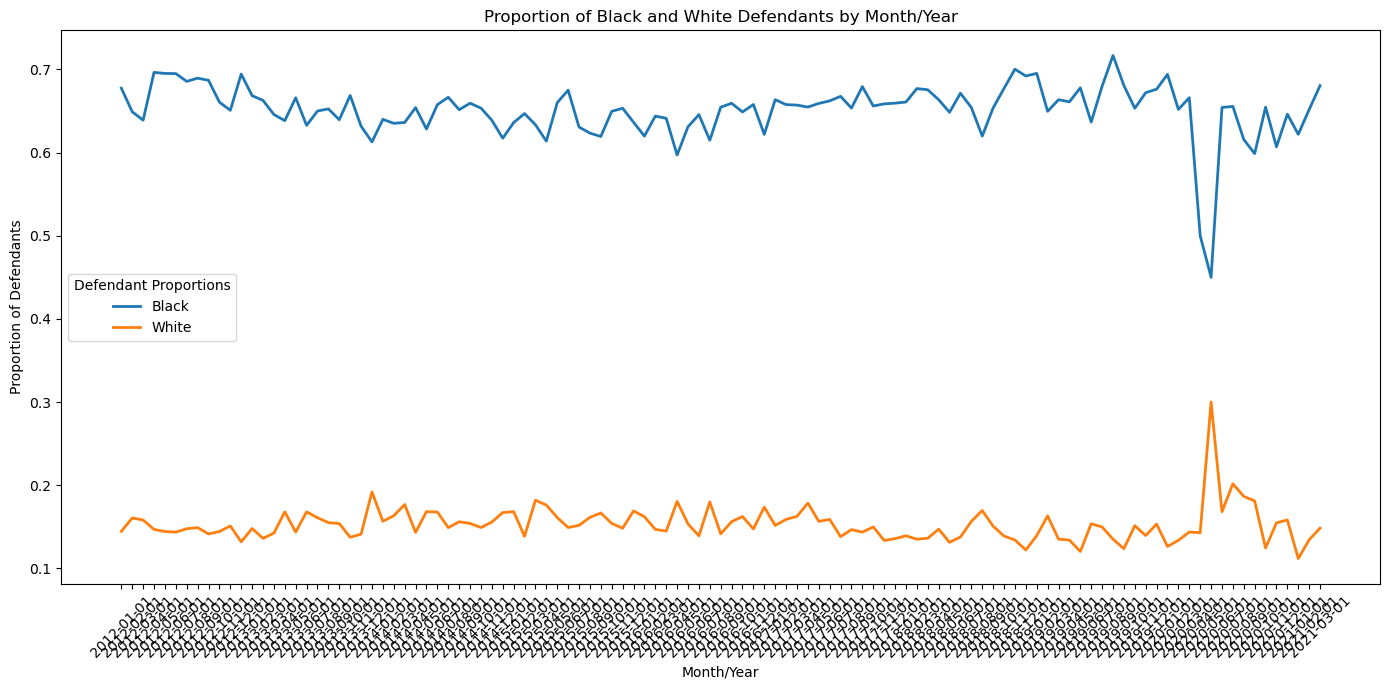

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [89]:
# Group by the year-month column (sentenceym_derived)
df2_grouped = df2.groupby("sentenceym_derived")

# Calculate the total number of unique cases per group (returns a series)
df2_total_cases = df2_grouped["CASE_ID"].nunique()

# Calculate the number of True values (count of Black and White defendants) per group
df2_black_defendants = df2_grouped["is_black_derived"].sum()
df2_white_defendants = df2_grouped["is_white_derived"].sum()

# Create a DataFrame directly, without merging
df2table = pd.DataFrame(index=df2_total_cases.index)

# Assign the results to the DataFrame
df2table["total_cases"] = df2_total_cases
df2table["black_defendants"] = df2_black_defendants
df2table["white_defendants"] = df2_white_defendants

# Calculate the proportions for Black and White defendants
df2table["prop_black"] = df2table["black_defendants"] / df2table["total_cases"]
df2table["prop_white"] = df2table["white_defendants"] / df2table["total_cases"]

# Display the table
print(df2table)

# Plot the data
plt.figure(figsize=(14, 7))
plt.plot(df2table.index.astype(str), df2table['prop_black'], label='Black Defendants', linewidth=2)
plt.plot(df2table.index.astype(str), df2table['prop_white'], label='White Defendants', linewidth=2)

# Add legend, title, and labels
plt.legend(title='Defendant Proportions', labels=['Black', 'White'])
plt.title('Proportion of Black and White Defendants by Month/Year')
plt.xlabel('Month/Year')
plt.ylabel('Proportion of Defendants')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

#Use mathematical notation to write out each of the proportions using summation notation in a 1-2 sentence writeup describing trends. What seems to be going on in April and May 2020?
#In April and May 2020, there was a significant decrease in the proportion of Black defendants whilst the proportion of White defendants conversely experienced a huge upward spike.

from IPython.display import display, Math
# B_t: Total Black defendants in month/year t
# W_t: Total White defendants in month/year t
# I_{B,i}: Indicator if a Black defendant is incarcerated in month/year t
# I_{W,j}: Indicator if a White defendant is incarcerated in month/year t

# Display the proportion for Black defendants incarcerated
display(Math(r'P_{B,t} = \frac{\sum_{i=1}^{B_t} \text{is\_incarcerated}_{B,i}}{B_t}'))

# Display the proportion for White defendants incarcerated
display(Math(r'P_{W,t} = \frac{\sum_{j=1}^{W_t} \text{is\_incarcerated}_{W,j}}{W_t}'))

# Display the difference between the two proportions
display(Math(r'D_t = \left(\frac{\sum_{i=1}^{B_t} \text{is\_incarcerated}_{B,i}}{B_t}\right) - \left(\frac{\sum_{j=1}^{W_t} \text{is\_incarcerated}_{W,j}}{W_t}\right)'))

## 2.2: Investigating the first type of disparity: probation versus incaceration (10 points)

One type of disparity beyond who arrives at the sentencing stage is whether the defendant receives probation or incaceration.

According to the codebook, incarceration is indicated by `COMMITMENT_TYPE` == "Illinois Department of Corrections"

Recreate the previous plot but where the y axis represents the difference between the following proportions (can be either Black - White or White - Black but make sure to label), adding a smoothed line:

- Percent of black defendants who are incarcerated out of all black defendants that month/year 
- Percent of white defendants who are incarcerated out of all white defendants that month/year 

In a markdown cell after, write 1-2 sentences on your observations of trends over time. Do gaps seem to be widening or increasing?

<Figure size 1400x700 with 0 Axes>

<Axes: ylabel='incarceration_diff'>

Text(0.5, 1.0, 'Difference in Incarceration Rates Between Black and White Defendants by Month/Year')

Text(0.5, 0, 'Month/Year')

Text(0, 0.5, 'Proportion Difference (Black - White)')

([<matplotlib.axis.XTick at 0x28f3e8230>,
 [Text(0, 0, '2012-01-01'),
  Text(12, 0, '2013-01-01'),
  Text(24, 0, '2014-01-01'),
  Text(36, 0, '2015-01-01'),
  Text(48, 0, '2016-01-01'),
  Text(60, 0, '2017-01-01'),
  Text(72, 0, '2018-01-01'),
  Text(84, 0, '2019-01-01'),
  Text(96, 0, '2020-01-01'),
  Text(108, 0, '2021-01-01')])

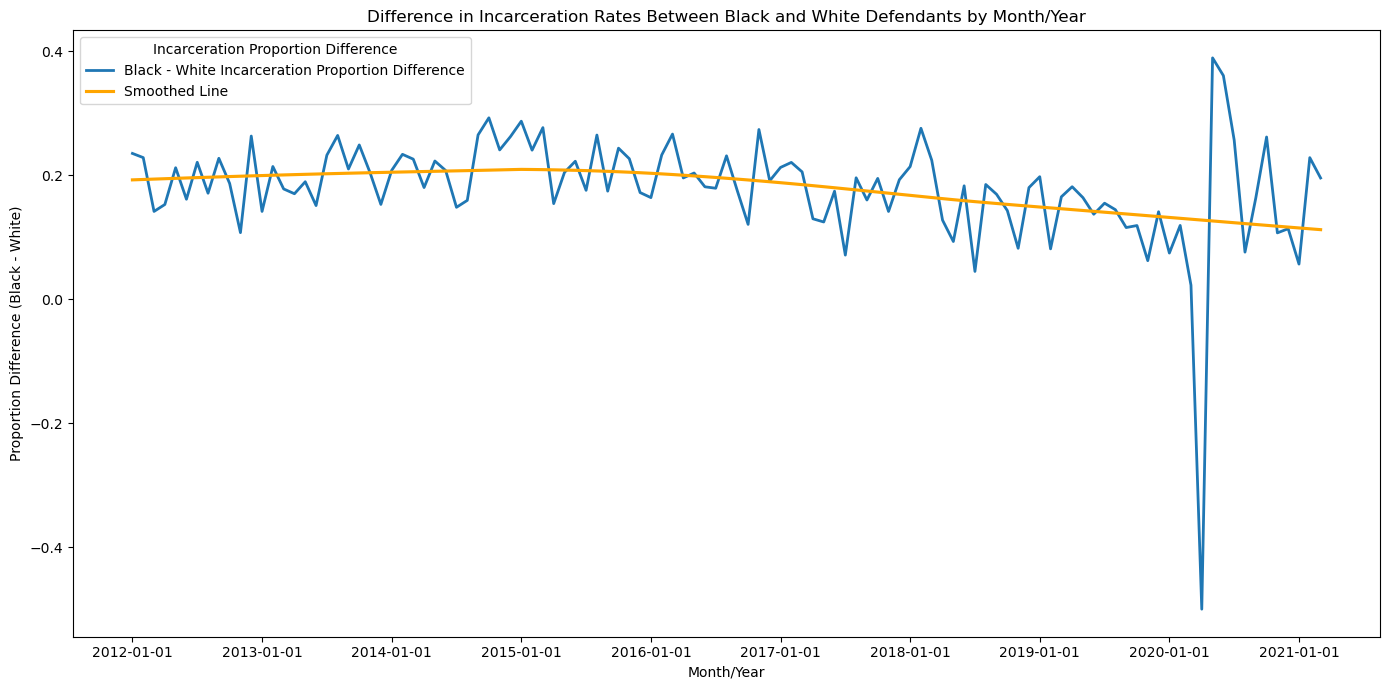

In [93]:
import seaborn as sns

# Create a column to indicate whether a defendant was incarcerated
df2['is_incarcerated'] = df2['COMMITMENT_TYPE'] == "Illinois Department of Corrections"

# Group by month_year to calculate total Black and White defendants and their incarceration rates
monthly_incarceration = df2.groupby('sentenceym_derived').agg(
    total_black_defendants=('is_black_derived', lambda x: (x == True).sum()),
    total_white_defendants=('is_white_derived', lambda x: (x == True).sum()),
    black_incarcerated=('is_incarcerated', lambda x: ((df2['is_black_derived'] == True) & (x == True)).sum()),
    white_incarcerated=('is_incarcerated', lambda x: ((df2['is_white_derived'] == True) & (x == True)).sum())
).reset_index()

# Calculate the proportion of Black and White defendants incarcerated out of all Black/White defendants that month
monthly_incarceration['prop_black_incarcerated'] = monthly_incarceration['black_incarcerated'] / monthly_incarceration['total_black_defendants']
monthly_incarceration['prop_white_incarcerated'] = monthly_incarceration['white_incarcerated'] / monthly_incarceration['total_white_defendants']

# Calculate the difference between the two proportions (Black - White)
monthly_incarceration['incarceration_diff'] = monthly_incarceration['prop_black_incarcerated'] - monthly_incarceration['prop_white_incarcerated']

# Plot the difference with a smoothed line
plt.figure(figsize=(14, 7))
plt.plot(monthly_incarceration['sentenceym_derived'].astype(str), monthly_incarceration['incarceration_diff'], label='Black - White Incarceration Proportion Difference', linewidth=2)

# Add a smoothed line using seaborn
sns.regplot(x=monthly_incarceration.index, y=monthly_incarceration['incarceration_diff'], scatter=False, lowess=True, label='Smoothed Line', color='orange')

# Add legend, title, and labels
plt.legend(title='Incarceration Proportion Difference')
plt.title('Difference in Incarceration Rates Between Black and White Defendants by Month/Year')
plt.xlabel('Month/Year')
plt.ylabel('Proportion Difference (Black - White)')
plt.xticks(ticks=monthly_incarceration.index[::12], labels=monthly_incarceration['sentenceym_derived'].astype(str)[::12])  
plt.tight_layout()

# Show the plot
plt.show()

Answer to whether the gaps have been widening: 
- The proportion difference has been fluctuating. It seems that the gap has been widening, espcially with more spikes and higher peaks. The first quarter in 2020 also had a major downward spike, which still supports the idea that the proportion difference is widening.  

## 2.3: Investigating mechanisms: incaceration rates by charge

Your colleague sees the previous graph and is worried that the gap could be different---either wider or smaller---if you adjust for the fact that prosecutors have discretion in what crimes to charge defendants with. If white defendants are charged with crimes that tend to receive probation rather than incarceration, that could explain some of the gaps.

In the next questions, you'll begin to investigate this.

### 2.3.1: Find the most common offenses (3 points)

First, create a set of 'frequent offenses' that represent (over the entire period) the union of the 10 offenses Black defendant are most likely to be charged with and the 10 offenses white defendants are most likely to be charged with (might be far less than 20 total if there's a lot of overlap in common charges)

Use the `simplified_offense_derived` for this

In [98]:
# Identify the top 10 offenses for Black defendants over the entire period
black_offenses = df2[df2['is_black_derived'] == True]['simplified_offense_derived'].value_counts().nlargest(10).index

# Identify the top 10 offenses for White defendants over the entire period
white_offenses = df2[df2['is_white_derived'] == True]['simplified_offense_derived'].value_counts().nlargest(10).index

# Create the union of these two sets to get the 'frequent offenses'
frequent_offenses = set(black_offenses).union(set(white_offenses))

# Display the list of frequent offenses
print(frequent_offenses)

{'Driving With Suspended Or Revoked License', 'Theft', 'Retail Theft', 'Battery', 'Other Offense', 'UUW - Unlawful Use of Weapon', 'Vehicle-related', 'Residential Burglary', 'Burglary', 'Narcotics', 'Robbery', 'DUI'}


### 2.3.2: Look at incarceration rates (again just whether incarcerated) by race and offense type for these top offenses (3 points)

Print a wide-format version of the resulting table (so each row is an offense type, one col is black incarceration rate for that offense type; another is the white incarceration rate) and interpret. 

Which offenses show the largest disparities in judges being less likely to sentence White defendants to incarceration/more likely to offer those defendants probation?
- Interpretation: Unlawful Use of Weapon, Robbery, Narcotics, Vehicle-related, and Battery are the top 5 crime themes where judges are less likely to setence White defendants as they have the biggest disparity values (shown in the sorted table).



In [101]:
# Filter the dataset to include only offenses in the 'frequent_offenses' set
df2_frequent = df2[df2['simplified_offense_derived'].isin(frequent_offenses)]

# Create a column indicating if the defendant was incarcerated (assuming DISPOSITION_DATE indicates incarceration if non-null)
df2_frequent['incarcerated'] = df2["is_incarcerated"] == True

# Group by offense type and calculate incarceration rates for Black and White defendants
offense_summary = df2_frequent.groupby('simplified_offense_derived').agg(
    black_incarceration_rate=('incarcerated', lambda x: x[df2_frequent['is_black_derived'] == True].sum() / x.sum()),
    white_incarceration_rate=('incarcerated', lambda x: x[df2_frequent['is_white_derived'] == True].sum() / x.sum())
).reset_index()

# Calculate the disparity in incarceration rates
offense_summary['disparity'] = offense_summary['black_incarceration_rate'] - offense_summary['white_incarceration_rate']

# Identify offenses with the largest disparities
offense_summary_sorted = offense_summary.sort_values(by='disparity', ascending=False)
print("Offenses with largest disparities:")
print(offense_summary_sorted[['simplified_offense_derived', 'black_incarceration_rate', 'white_incarceration_rate', 'disparity']])

Offenses with largest disparities:
                   simplified_offense_derived  black_incarceration_rate  \
10               UUW - Unlawful Use of Weapon                  0.829901   
4                                   Narcotics                  0.854838   
8                                     Robbery                  0.792835   
11                            Vehicle-related                  0.736288   
0                                     Battery                  0.726742   
7                                Retail Theft                  0.709689   
3   Driving With Suspended Or Revoked License                  0.620162   
6                        Residential Burglary                  0.641347   
5                               Other Offense                  0.655814   
1                                    Burglary                  0.654006   
9                                       Theft                  0.653574   
2                                         DUI                  0.

/var/folders/39/n92n7brd1t5_t9yz154q31600000gn/T/ipykernel_28050/3678675292.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_frequent['incarcerated'] = df2["is_incarcerated"] == True


### 2.3.3: Examine whether this changes pre and post change to charging threshold for retail theft (13 points)

One important question is not only whether there are disparities by offense type but also whether these disparities are changing over time.

The SAO, for instance, announced in December of 2016 that they would no longer default to charging retail thefts of under \$1,000 as felonies. This change might have (1) decreased disparities or (2) increased disparities, depending on the correlation between race/ethnicity and magnitude of goods stolen: [news coverage](https://www.dnainfo.com/chicago/20161215/little-village/kim-foxx-raises-bar-for-retail-theft-felonies/). 

Focusing on `simplified_offense_derived` == "Retail theft." Using a function and/or loop (Dec. 2016 is always excluded as a transition month):

- Compare Black-White disparities before and after the change using a two-month bandwidth (so pre is October and November 2016; post is January and February 2017)

- Compare Black-White disparities before and after the change using a four-month bandwidth (so pre is August- November 2016; post is January - April 2017)

- Compare Black-White disparities using an eight-month bandwidth

- Compare Black-White disparities using a twelve-month bandwidth


------------------ 

- Print a table with the results (any organization is fine as long as it's clear)  

- Create a bar chart where the x axis represents different bandwidths (2, 4, etc); the y axis the size of the Black-White gap in whether the defendant receives incarceration, and for each of the x axis points, you have one shaded bar representing "before" the change, another representing "after" the change (make sure that before is ordered before after and the bandwidths are from smallest to largest)

*Note*: for each of the bandwidths include dates the entire month (e.g., for the first, include not only 02-01-2017 but everything up through 02-28-2017; easiest way is for the subsetting to use the rounded `sentenceym_derived`). Also make sure to only include white or black defendants.


**Extra credit**: because the bandwidths have different sample sizes, a better viz incorporates measures of uncertainty. Add standard errors to the estimates using the formula: $(\dfrac{p(1-p)}{n})^{0.5}$ where $p$ is the gap and $N$ is the number of cases in each bandwidth period 


/var/folders/39/n92n7brd1t5_t9yz154q31600000gn/T/ipykernel_28050/3364361865.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_retail_theft['sentenceym_derived'] = pd.to_datetime(df2_retail_theft['sentenceym_derived'], errors='coerce')
/var/folders/39/n92n7brd1t5_t9yz154q31600000gn/T/ipykernel_28050/3364361865.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_retail_theft['month'] = df2_retail_theft['sentenceym_derived'].dt.to_period('M')


,Bandwidth,Pre-change Disparity,Post-change Disparity
0,2,0.087912,0.154949
1,4,0.081588,0.081615
2,8,0.115538,0.081615
3,12,0.143144,0.081615


Black-White Disparities in Incarceration Rates:
   Bandwidth  Pre-change Disparity  Post-change Disparity
0          2              0.087912               0.154949
1          4              0.081588               0.081615
2          8              0.115538               0.081615
3         12              0.143144               0.081615
0    0.087912
1    0.081588
2    0.115538
3    0.143144
Name: Pre-change Disparity, dtype: float64


<Figure size 1000x600 with 0 Axes>

<BarContainer object of 4 artists>

<BarContainer object of 4 artists>

Text(0.5, 0, 'Bandwidth (Months)')

Text(0, 0.5, 'Disparity in Incarceration Rate (Black - White)')

Text(0.5, 1.0, 'Black-White Disparity Before and After Change in Retail Theft Policy')

([<matplotlib.axis.XTick at 0x28f2ee510>,
 [Text(0.175, 0, '2'),
  Text(1.175, 0, '4'),
  Text(2.175, 0, '8'),
  Text(3.175, 0, '12')])

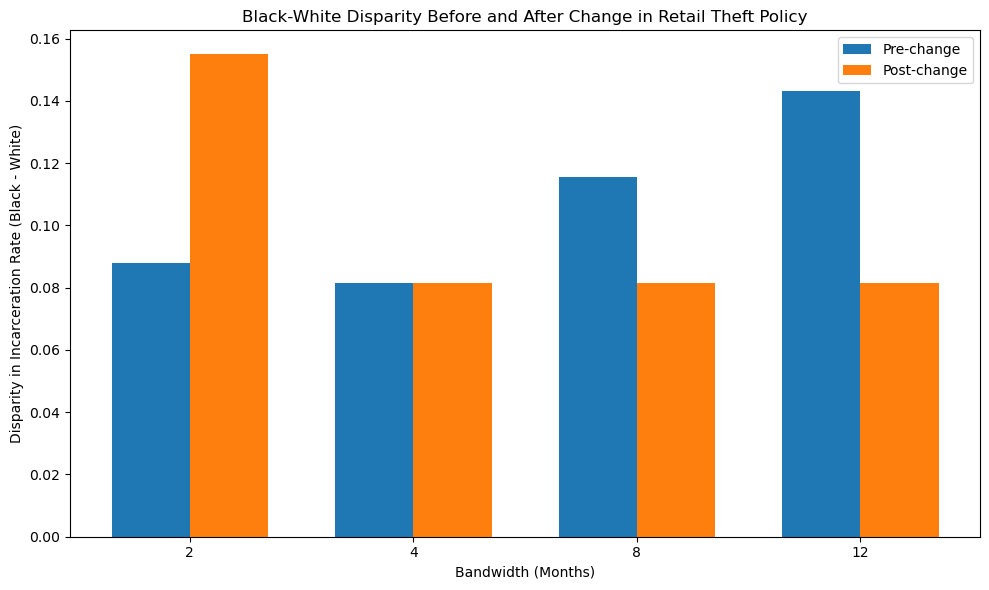

In [104]:
# Filter the dataset to include only 'Retail theft' offenses for Black and White defendants
df2_retail_theft = df2[(df2['simplified_offense_derived'] == "Retail Theft") &
                     (df2['is_black_derived'] | df2['is_white_derived'])]

# Convert sentence date to monthly period for easier comparison
df2_retail_theft['sentenceym_derived'] = pd.to_datetime(df2_retail_theft['sentenceym_derived'], errors='coerce')
df2_retail_theft['month'] = df2_retail_theft['sentenceym_derived'].dt.to_period('M')

# Define the function to calculate disparities based on different bandwidths
def calculate_disparity(bandwidth):
    pre_start = '2016-08' if bandwidth >= 4 else '2016-10'
    pre_end = '2016-11'
    post_start = '2017-01'
    post_end = '2017-04' if bandwidth >= 4 else '2017-02'
    if bandwidth == 8:
        pre_start = '2016-05'
        post_end = '2017-04'
    elif bandwidth == 12:
        pre_start = '2015-05'
        post_end = '2017-04'
        
    # Subset for pre-change and post-change periods
    pre_change = df2_retail_theft[(df2_retail_theft['month'] >= pre_start) & (df2_retail_theft['month'] <= pre_end)]
    post_change = df2_retail_theft[(df2_retail_theft['month'] >= post_start) & (df2_retail_theft['month'] <= post_end)]
    
    # Calculate incarceration rates for pre-change
    pre_black_incarceration = pre_change[pre_change['is_black_derived']]['is_incarcerated'].mean()
    pre_white_incarceration = pre_change[pre_change['is_white_derived']]['is_incarcerated'].mean()
    pre_disparity = pre_black_incarceration - pre_white_incarceration
    
    # Calculate incarceration rates for post-change
    post_black_incarceration = post_change[post_change['is_black_derived']]['is_incarcerated'].mean()
    post_white_incarceration = post_change[post_change['is_white_derived']]['is_incarcerated'].mean()
    post_disparity = post_black_incarceration - post_white_incarceration
    return {'Bandwidth': bandwidth, 'Pre-change Disparity': pre_disparity, 'Post-change Disparity': post_disparity}

# Calculate disparities for each bandwidth
results = [calculate_disparity(2), calculate_disparity(4), calculate_disparity(8), calculate_disparity(12)]
results_df2 = pd.DataFrame(results)

results_df2
# Display the results
print("Black-White Disparities in Incarceration Rates:")
print(results_df2)

print(results_df2['Pre-change Disparity'])

# Plot the disparities
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = range(len(results_df2))
plt.bar(index, results_df2['Pre-change Disparity'], width=bar_width, label='Pre-change', align='center')
plt.bar([i + bar_width for i in index], results_df2['Post-change Disparity'], width=bar_width, label='Post-change', align='center')

# Set chart details
plt.xlabel('Bandwidth (Months)')
plt.ylabel('Disparity in Incarceration Rate (Black - White)')
plt.title('Black-White Disparity Before and After Change in Retail Theft Policy')
plt.xticks([r + bar_width / 2 for r in index], ['2', '4', '8', '12'])
plt.legend()
plt.tight_layout()
plt.show()

### 2.3.3.1: Interpret the results (2 points)

Write a two-sentence interpretation of the results. What might this show about how people on both sides of the issue---those who argued that the retail theft policy change would narrow disparities; those who argued that the change may widen disparities--could support their claims? 

The graph would support both sides of the argument as there are some bandwindths with the policy implementing a change that would narrow disparities and some bandwindths that show a decrease in disparity. 
- Those who argued retail theft policy would narrow disparities would prefer the data use either an 8 or 12 bandwidth period
- Those who argued retail theft policy would widen disparities would prefer the 2 month bandwidth data set
- The 4 months bandwidth provides a neutral view between these two opposing arguments, which is interesting...